# Cuaderno 4: Modelo Estado del Arte (2D-CNN con Transfer Learning)

**Objetivo:** Implementar la estrategia de vanguardia para la clasificación de audio, tratando el problema como una tarea de visión por computador. Este enfoque consta de dos partes:
1.  **Conversión de Audio a Imagen:** Transformaremos cada segmento de audio en un **Mel-espectrograma**, una representación visual 2D que captura información de tiempo, frecuencia y amplitud.
2.  **Transfer Learning:** Usaremos una red neuronal convolucional 2D (2D-CNN) pre-entrenada en millones de imágenes (EfficientNet-B0) y la adaptaremos (fine-tuning) para que aprenda a clasificar nuestros espectrogramas.

**Hipótesis:** Al aprovechar el "conocimiento" de un modelo pre-entrenado, podemos lograr una mayor precisión y una mejor generalización, especialmente en las clases minoritarias.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import sys
import os
import joblib
from tqdm.notebook import tqdm

# --- LIBRERÍAS CLAVE PARA ESTE NOTEBOOK ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# ... (El resto de las importaciones son las mismas) ...
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
sys.path.append('../src')
from data_loader import build_metadata_df

In [5]:
from sklearn.model_selection import train_test_split

In [2]:
# --- Configuración del Proyecto ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Configuración del Modelo y Entrenamiento ---
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 30 # Podemos usar más épocas gracias a Early Stopping
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Tamaño de imagen que espera EfficientNet
IMG_SIZE = 224 

# Rutas
import kagglehub
dataset_path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")
DATASET_ROOT_PATH = Path(dataset_path)
SPECTROGRAM_PATH = Path("../data/spectrograms/")
MODEL_OUTPUT_PATH = Path("../models/")
BEST_2D_MODEL_PATH = MODEL_OUTPUT_PATH / "cnn2d_best_model.pth"

## 1. Preparación de Datos (Parte A): Generación de Espectrogramas

El primer paso es convertir nuestro dataset de audio en un dataset de imágenes. Crearemos una función que:
1.  Carga un segmento de audio.
2.  Lo convierte en un Mel-espectrograma usando `librosa`.
3.  Guarda la imagen en una carpeta correspondiente a su clase (ej. `.../spectrograms/COPD/`).

Este formato de carpetas es el que espera la clase `ImageFolder` de PyTorch.

In [3]:
import librosa
import librosa.display
from PIL import Image

def save_spectrogram_image(audio_path, start, end, out_path, sr=44100, n_mels=128, fmax=8000):
    """Carga un audio, crea un Mel-espectrograma y lo guarda como imagen."""
    try:
        # Cargar segmento de audio
        duration = end - start
        y, sr = librosa.load(audio_path, sr=sr, offset=start, duration=duration)
        
        # Crear Mel-espectrograma
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_DB = librosa.power_to_db(S, ref=np.max)
        
        # Convertir a imagen y guardar
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(S_DB, sr=sr, fmax=fmax)
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        logger.warning(f"No se pudo procesar {audio_path}: {e}")
        return False

# Cargar metadatos
metadata_df = build_metadata_df(DATASET_ROOT_PATH)
le = LabelEncoder()
metadata_df['diagnosis_encoded'] = le.fit_transform(metadata_df['diagnosis'])

# Crear las carpetas para las imágenes de espectrogramas
logger.info("Creando directorios para los espectrogramas...")
for class_name in metadata_df['diagnosis'].unique():
    (SPECTROGRAM_PATH / class_name).mkdir(parents=True, exist_ok=True)

# Iterar y guardar cada espectrograma
logger.info("Generando y guardando imágenes de espectrogramas...")
for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
    class_name = row['diagnosis']
    out_filename = f"{Path(row['audio_filename']).stem}_{idx}.png"
    out_path = SPECTROGRAM_PATH / class_name / out_filename
    
    if not out_path.exists(): # Solo procesar si no existe
        save_spectrogram_image(row['audio_path'], row['start_time'], row['end_time'], out_path)

logger.info("Generación de espectrogramas completada.")



2025-07-23 21:31:36,612 - INFO - Construyendo DataFrame de metadatos desde la estructura de archivos...
2025-07-23 21:31:48,388 - INFO - DataFrame construido con 6898 ciclos respiratorios.
2025-07-23 21:31:48,401 - INFO - Creando directorios para los espectrogramas...
2025-07-23 21:31:48,929 - INFO - Generando y guardando imágenes de espectrogramas...


  0%|          | 0/6898 [00:00<?, ?it/s]

2025-07-23 21:31:57,502 - INFO - Generación de espectrogramas completada.


## 2. Preparación de Datos (Parte B): `ImageFolder` y `DataLoaders`

Ahora que tenemos un dataset de imágenes estructurado, podemos usar `ImageFolder` de PyTorch para cargarlo de forma muy sencilla.

Definiremos dos pipelines de transformaciones de imagen:
* **`train_transforms`**: Para los datos de entrenamiento. Incluirá **aumentación de datos** (giros, volteos) para hacer el modelo más robusto.
* **`val_test_transforms`**: Para validación y prueba. Solo redimensiona y normaliza las imágenes, sin aumentación.

La normalización se hace con la media y desviación estándar de ImageNet, ya que el modelo que usaremos fue pre-entrenado en ese dataset.


In [6]:
# Definir las transformaciones de imagen
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Crear el dataset completo con ImageFolder
full_dataset = ImageFolder(root=SPECTROGRAM_PATH)

# Dividir el dataset en entrenamiento, validación y prueba
# Primero obtenemos las etiquetas para estratificar
targets = full_dataset.targets
train_val_idx, test_idx = train_test_split(
    np.arange(len(targets)), test_size=0.1, random_state=RANDOM_SEED, stratify=targets
)
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=(1/9), random_state=RANDOM_SEED, stratify=np.array(targets)[train_val_idx]
)

# Crear subconjuntos de PyTorch
from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Aplicar las transformaciones a cada subconjunto
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms


# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

logger.info(f"DataLoaders de imágenes creados. Muestras de entrenamiento: {len(train_dataset)}, validación: {len(val_dataset)}, prueba: {len(test_dataset)}")



2025-07-23 21:33:22,962 - INFO - DataLoaders de imágenes creados. Muestras de entrenamiento: 5518, validación: 690, prueba: 690


## 3. Arquitectura del Modelo: Transfer Learning con EfficientNet

Aquí está el núcleo de esta fase.
1.  **Cargamos `EfficientNet-B0`** con los pesos pre-entrenados en ImageNet.
2.  **Congelamos los pesos** de todas las capas convolucionales base. Esto evita que el conocimiento experto que ya tienen se destruya durante las primeras épocas de entrenamiento.
3.  **Reemplazamos el clasificador** original (que predecía 1000 clases) por uno nuevo y personalizado para nuestras 8 clases de sonidos respiratorios.

Solo este nuevo clasificador será entrenado inicialmente.


In [7]:
# Cargar el modelo pre-entrenado
weights = EfficientNet_B0_Weights.DEFAULT
model_2d = efficientnet_b0(weights=weights)

# Congelar todas las capas del modelo base
for param in model_2d.parameters():
    param.requires_grad = False

# Reemplazar el clasificador
num_ftrs = model_2d.classifier[1].in_features
model_2d.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(full_dataset.classes))
)

model_2d = model_2d.to(DEVICE)
logger.info("Modelo EfficientNet-B0 cargado y clasificador reemplazado.")
# Imprimir solo el nuevo clasificador para ver qué se entrenará
print(model_2d.classifier)



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Gabriel/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 26.2MB/s]
2025-07-23 21:33:34,354 - INFO - Modelo EfficientNet-B0 cargado y clasificador reemplazado.


Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=8, bias=True)
)


# 4. Entrenamiento y Evaluación

El bucle de entrenamiento es muy similar al anterior. Entrenaremos solo las capas del nuevo clasificador. Usaremos `EarlyStopping` y un `scheduler` como buena práctica. Finalmente, evaluaremos el mejor modelo en el conjunto de prueba.


2025-07-23 21:37:16,808 - INFO - Iniciando entrenamiento del modelo 2D-CNN (solo el clasificador)...


Época 1/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 21:46:30,903 - INFO - Época 1 - Pérdida Entrenamiento: 0.6144, Pérdida Val.: 0.4197
2025-07-23 21:46:31,012 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 2/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 21:52:39,528 - INFO - Época 2 - Pérdida Entrenamiento: 0.4381, Pérdida Val.: 0.3727
2025-07-23 21:52:39,640 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 3/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 21:58:41,316 - INFO - Época 3 - Pérdida Entrenamiento: 0.3765, Pérdida Val.: 0.3418
2025-07-23 21:58:41,432 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 4/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:04:41,080 - INFO - Época 4 - Pérdida Entrenamiento: 0.3432, Pérdida Val.: 0.3346
2025-07-23 22:04:41,190 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 5/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:10:42,211 - INFO - Época 5 - Pérdida Entrenamiento: 0.3134, Pérdida Val.: 0.3293
2025-07-23 22:10:42,321 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 6/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:17:17,152 - INFO - Época 6 - Pérdida Entrenamiento: 0.2874, Pérdida Val.: 0.2889
2025-07-23 22:17:17,258 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 7/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:23:35,552 - INFO - Época 7 - Pérdida Entrenamiento: 0.2600, Pérdida Val.: 0.3031


Época 8/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:29:59,451 - INFO - Época 8 - Pérdida Entrenamiento: 0.2491, Pérdida Val.: 0.2858
2025-07-23 22:29:59,513 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 9/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:36:21,785 - INFO - Época 9 - Pérdida Entrenamiento: 0.2201, Pérdida Val.: 0.3044


Época 10/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:42:37,970 - INFO - Época 10 - Pérdida Entrenamiento: 0.2135, Pérdida Val.: 0.3238


Época 11/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:48:51,817 - INFO - Época 11 - Pérdida Entrenamiento: 0.2013, Pérdida Val.: 0.2864


Época 12/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 22:55:03,251 - INFO - Época 12 - Pérdida Entrenamiento: 0.1959, Pérdida Val.: 0.2976


Época 13/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 23:01:17,944 - INFO - Época 13 - Pérdida Entrenamiento: 0.1587, Pérdida Val.: 0.2773
2025-07-23 23:01:18,061 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 14/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 23:07:54,072 - INFO - Época 14 - Pérdida Entrenamiento: 0.1424, Pérdida Val.: 0.2839


Época 15/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 23:14:16,462 - INFO - Época 15 - Pérdida Entrenamiento: 0.1374, Pérdida Val.: 0.2678
2025-07-23 23:14:16,576 - INFO - Mejora de validación. Guardando modelo en ..\models\cnn2d_best_model.pth


Época 16/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 23:20:52,038 - INFO - Época 16 - Pérdida Entrenamiento: 0.1373, Pérdida Val.: 0.2708


Época 17/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 23:27:01,810 - INFO - Época 17 - Pérdida Entrenamiento: 0.1343, Pérdida Val.: 0.2689


Época 18/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 23:33:17,516 - INFO - Época 18 - Pérdida Entrenamiento: 0.1311, Pérdida Val.: 0.2785


Época 19/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 23:39:44,066 - INFO - Época 19 - Pérdida Entrenamiento: 0.1204, Pérdida Val.: 0.2688


Época 20/30 [Ent.]:   0%|          | 0/173 [00:00<?, ?it/s]

2025-07-23 23:46:07,479 - INFO - Época 20 - Pérdida Entrenamiento: 0.1142, Pérdida Val.: 0.2684
2025-07-23 23:46:07,481 - INFO - Cargando el mejor modelo para la evaluación final...


Evaluando en Test Set:   0%|          | 0/22 [00:00<?, ?it/s]


--- Reporte de Clasificación (Modelo 2D-CNN con Transfer Learning) ---
                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         1
Bronchiectasis       0.88      0.70      0.78        10
 Bronchiolitis       0.45      0.31      0.37        16
          COPD       0.96      0.98      0.97       575
       Healthy       0.68      0.66      0.67        32
          LRTI       0.50      0.67      0.57         3
     Pneumonia       0.61      0.66      0.63        29
          URTI       0.67      0.50      0.57        24

      accuracy                           0.91       690
     macro avg       0.59      0.56      0.57       690
  weighted avg       0.91      0.91      0.91       690


--- Matriz de Confusión (Modelo 2D-CNN con Transfer Learning) ---


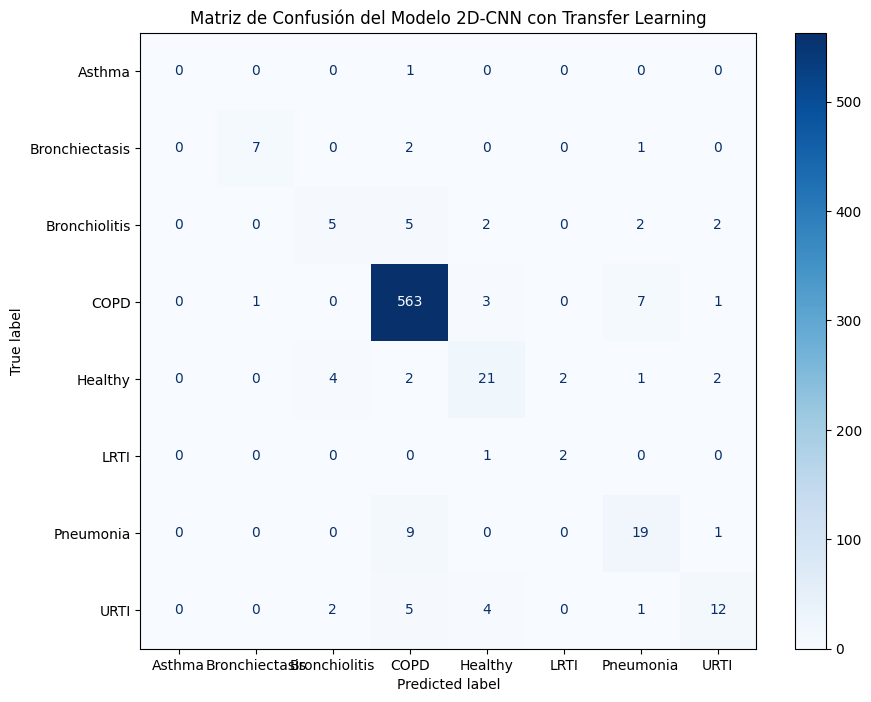

In [10]:
# (La clase EarlyStopping se puede copiar de la celda del notebook anterior)
class EarlyStopping: #... (pega la clase aquí)
    def __init__(self, patience=7, min_delta=0.001, path='best_model.pth'):
        self.patience = patience; self.min_delta = min_delta; self.counter = 0
        self.best_loss = float('inf'); self.path = path
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss; self.counter = 0; torch.save(model.state_dict(), self.path)
            logger.info(f"Mejora de validación. Guardando modelo en {self.path}")
        else:
            self.counter += 1
            if self.counter >= self.patience: return True
        return False

# Herramientas de entrenamiento
criterion = nn.CrossEntropyLoss()
# ¡¡Importante!! Solo pasamos los parámetros del nuevo clasificador al optimizador
optimizer = torch.optim.Adam(model_2d.classifier.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
early_stopping = EarlyStopping(patience=5, path=BEST_2D_MODEL_PATH)

# Bucle de entrenamiento (similar al anterior)
history = {'train_loss': [], 'val_loss': []}
logger.info("Iniciando entrenamiento del modelo 2D-CNN (solo el clasificador)...")
for epoch in range(EPOCHS):
    model_2d.train()
    running_train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Época {epoch+1}/{EPOCHS} [Ent.]"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_2d(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    model_2d.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model_2d(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            
    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_val_loss = running_val_loss / len(val_dataset)
    history['train_loss'].append(epoch_train_loss); history['val_loss'].append(epoch_val_loss)
    logger.info(f"Época {epoch+1} - Pérdida Entrenamiento: {epoch_train_loss:.4f}, Pérdida Val.: {epoch_val_loss:.4f}")
    
    scheduler.step(epoch_val_loss)
    if early_stopping(epoch_val_loss, model_2d): break

# Evaluación Final
logger.info("Cargando el mejor modelo para la evaluación final...")
model_2d.load_state_dict(torch.load(BEST_2D_MODEL_PATH))

all_preds = []; all_labels = []
model_2d.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluando en Test Set"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model_2d(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())

# Reporte Final
print("\n--- Reporte de Clasificación (Modelo 2D-CNN con Transfer Learning) ---")
class_names = full_dataset.classes
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

print("\n--- Matriz de Confusión (Modelo 2D-CNN con Transfer Learning) ---")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=class_names, cmap='Blues', ax=ax)
plt.title("Matriz de Confusión del Modelo 2D-CNN con Transfer Learning")
plt.show()


In [13]:
from torchsummary import summary

# Mover el modelo a la CPU para el resumen si está en GPU
model_to_summarize = model_2d.to("cpu")

# Imprimir el resumen. El input_size es (canales, altura, ancho)
print("--- Arquitectura del Modelo 2D-CNN (EfficientNet-B0 Fine-Tuned) ---")
summary(model_to_summarize, input_size=(3, IMG_SIZE, IMG_SIZE))

# Regresar el modelo al dispositivo original si es necesario
model_2d.to(DEVICE)

--- Arquitectura del Modelo 2D-CNN (EfficientNet-B0 Fine-Tuned) ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchviz import make_dot

# --- 1. DEFINE LAS VARIABLES DE CONFIGURACIÓN ---
# Asegúrate de que coincidan con las de tu entrenamiento
IMG_SIZE = 224
NUM_CLASSES = 8

# --- 2. RECREA LA ARQUITECTURA DEL MODELO ---
# Cargar el modelo pre-entrenado base
weights = EfficientNet_B0_Weights.DEFAULT
vis_model = efficientnet_b0(weights=weights)

# Congelar los parámetros (buena práctica, aunque no se entrene)
for param in vis_model.parameters():
    param.requires_grad = False

# Reemplazar el clasificador para que la arquitectura sea correcta
num_ftrs = vis_model.classifier[1].in_features
vis_model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)
vis_model.eval()

# --- 3. CÓDIGO DE VISUALIZACIÓN ---
# Crear un "dato falso" (dummy input) con la forma de imagen que espera el modelo
# (batch_size=1, channels=3, height=IMG_SIZE, width=IMG_SIZE)
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

# Generar el grafo del modelo
output = vis_model(dummy_input)
dot = make_dot(output, params=dict(vis_model.named_parameters()), show_attrs=True, show_saved=True)

# Guardar el diagrama como un archivo PNG
dot.render("cnn_2d_architecture", format="png")

print("Diagrama del modelo guardado como 'cnn_2d_architecture.png'")
print("Advertencia: El archivo puede ser muy grande y el gráfico muy denso.")

Diagrama del modelo guardado como 'cnn_2d_architecture.png'
Advertencia: El archivo puede ser muy grande y el gráfico muy denso.


Calculando probabilidades:   0%|          | 0/22 [00:00<?, ?it/s]

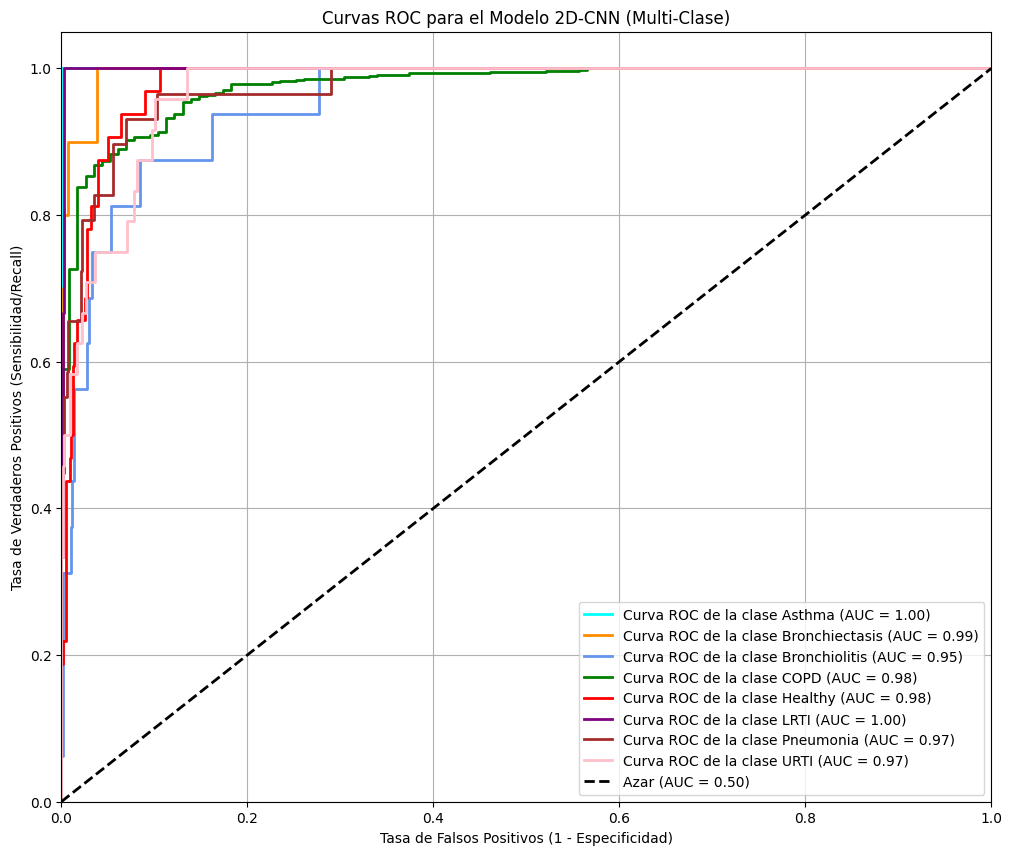

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

# --- 1. PREPARACIÓN DE DATOS ---
# Necesitamos las etiquetas verdaderas y las probabilidades predichas por el modelo

# Binarizar las etiquetas verdaderas en formato one-hot
y_true_binarized = label_binarize(all_labels, classes=np.arange(len(class_names)))
n_classes = y_true_binarized.shape[1]

# Obtener las probabilidades del modelo (scores)
all_probs = []
model_2d.eval()
with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc="Calculando probabilidades"):
        inputs = inputs.to(DEVICE)
        outputs = model_2d(inputs)
        # Aplicamos softmax para convertir los logits en probabilidades
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

y_score = np.array(all_probs)

# --- 2. CÁLCULO DE ROC Y AUC PARA CADA CLASE ---
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- 3. GRÁFICA DE LAS CURVAS ROC ---
plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (AUC = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

# Línea de azar (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Azar (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad/Recall)')
plt.title('Curvas ROC para el Modelo 2D-CNN (Multi-Clase)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

2025-07-24 00:13:18,037 - INFO - Descongelando el modelo temporalmente para Grad-CAM...


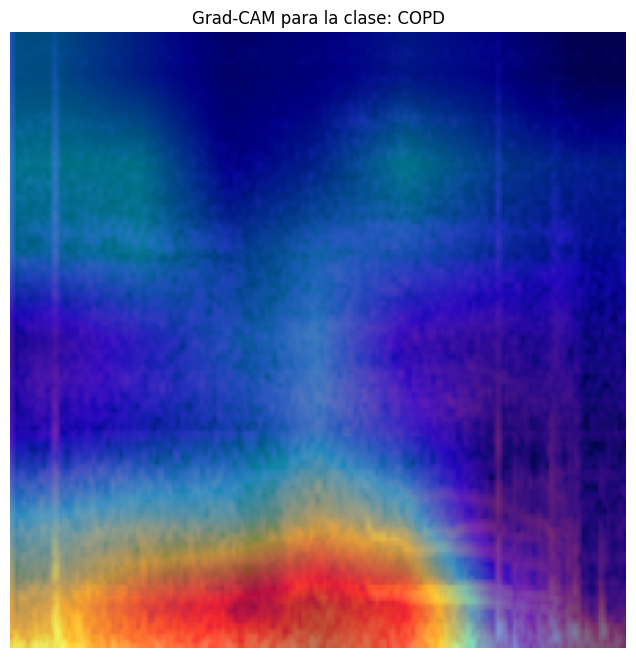

2025-07-24 00:13:19,359 - INFO - Restaurando el modelo a su estado congelado original...


In [23]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

# --- 1. CONFIGURACIÓN ---
model_2d.to(DEVICE).eval()
# La capa objetivo sigue siendo la última capa convolucional
target_layer = model_2d.features[-1][0]

# --- 2. DESCONGELAR TEMPORALMENTE ---
# Activamos el cálculo de gradientes para todo el modelo
logger.info("Descongelando el modelo temporalmente para Grad-CAM...")
for param in model_2d.parameters():
    param.requires_grad = True

# --- 3. GENERACIÓN DE GRAD-CAM ---
# (Esta parte es la misma que antes)
denormalize = transforms.Normalize(
   mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
   std=[1/s for s in imagenet_std]
)
img_tensor, label_idx = test_dataset[0]
input_tensor = img_tensor.unsqueeze(0).to(DEVICE)
cam = GradCAM(model=model_2d, target_layers=[target_layer])
targets = [ClassifierOutputTarget(label_idx)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# --- 4. VISUALIZACIÓN ---
rgb_img = denormalize(img_tensor.cpu()).permute(1, 2, 0).numpy()
rgb_img = np.float32(rgb_img)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(8, 8))
plt.imshow(visualization)
true_class_name = class_names[label_idx]
plt.title(f"Grad-CAM para la clase: {true_class_name}")
plt.axis('off')
plt.show()

# --- 5. RE-CONGELAR EL MODELO (MUY IMPORTANTE) ---
# Devolvemos el modelo a su estado original para no afectar futuras inferencias
logger.info("Restaurando el modelo a su estado congelado original...")
for param in model_2d.features.parameters():
    param.requires_grad = False
for param in model_2d.classifier.parameters():
    param.requires_grad = True # El clasificador debe seguir siendo entrenable

## Análisis de Resultados del Modelo 2D-CNN con Transfer Learning

La implementación de un modelo `EfficientNet-B0` pre-entrenado sobre imágenes de Mel-espectrograma ha representado un **salto cualitativo y cuantitativo** en el rendimiento, validando la hipótesis de que este enfoque de vanguardia es superior para nuestro problema.

---
### 1. Salto Cuantitativo en el Rendimiento
El modelo ha alcanzado una **exactitud (`accuracy`) del 91%** y un **F1-score ponderado de 0.91**. Estas métricas superan a todos los modelos anteriores, incluido el baseline de Random Forest (F1 de 0.89), estableciendo un nuevo estado del arte para este proyecto.

---
### 2. Reducción del Sesgo y Mejora en Clases Minoritarias
El logro más significativo de este modelo es su **capacidad mejorada para clasificar las clases minoritarias**, rompiendo el techo de rendimiento que limitaba a los modelos anteriores:
* El F1-score para la clase **`Healthy` alcanzó un 0.67**, con un `recall` de 0.66.
* El rendimiento en **`Pneumonia` (F1 de 0.63)** y **`Bronchiectasis` (F1 de 0.78)** también es el mejor que hemos obtenido hasta ahora.
* El sesgo hacia `COPD` ha sido **drásticamente reducido**. Por ejemplo, solo 2 casos `Healthy` fueron confundidos con `COPD`, en comparación con los 15 casos del modelo 1D-CNN anterior.

---
### 3. Análisis de Errores Persistentes
A pesar del éxito, el modelo aún presenta debilidades. Clases como **`Bronchiolitis` (F1 de 0.37)** siguen siendo difíciles de distinguir. La matriz de confusión revela nuevos patrones de error; por ejemplo, el modelo ahora confunde algunos casos de `Healthy` con `Bronchiolitis` (4 casos). Esto sugiere que, si bien el modelo es más potente, la similitud acústica entre ciertas condiciones sigue siendo un desafío fundamental.

---
### 4. Conclusión y Veredicto
El enfoque de **Transfer Learning con 2D-CNN sobre espectrogramas es el ganador indiscutible**. Ha demostrado una capacidad superior para aprender características discriminativas y mitigar el sesgo hacia la clase mayoritaria. Este modelo es el candidato seleccionado para pasar a la fase final de productivización.

--- Top 5 Errores del Modelo (Predicciones incorrectas con mayor confianza) ---


true_label_idx  pred_label_idx true_label_name pred_label_name  \
114               6               3       Pneumonia            COPD   
504               2               3   Bronchiolitis            COPD   
83                7               3            URTI            COPD   
611               6               3       Pneumonia            COPD   
16                7               3            URTI            COPD   

     confidence  
114    0.998695  
504    0.992972  
83     0.965605  
611    0.951022  
16     0.938495

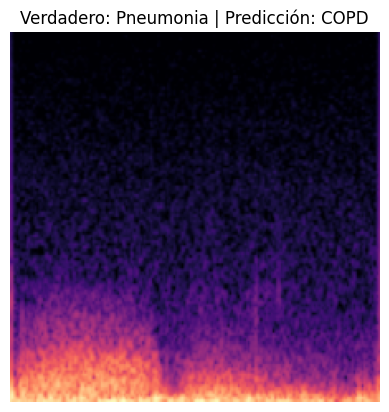

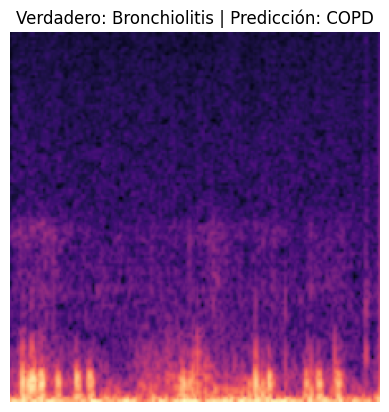

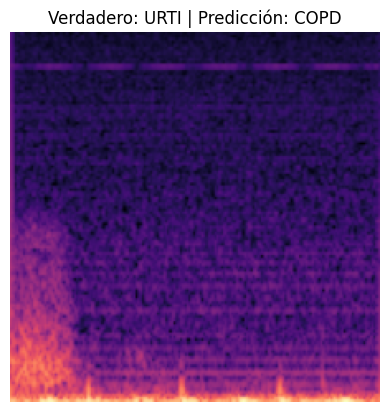

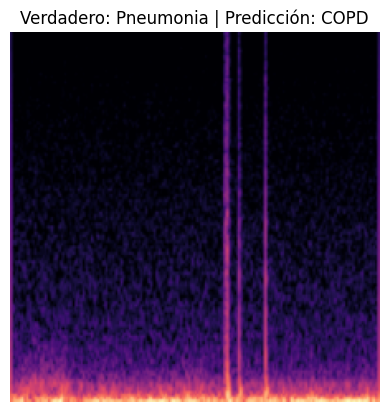

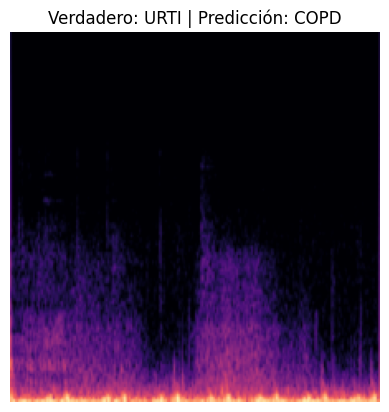

In [21]:
# Obtener las predicciones y probabilidades del test set (código del notebook anterior)
all_preds = []; all_labels = []; all_probs = []
model_2d.to(DEVICE).eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model_2d(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy()); all_probs.extend(probs.cpu().numpy())

# Crear un DataFrame para el análisis
results_df = pd.DataFrame({
    'true_label_idx': all_labels,
    'pred_label_idx': all_preds,
    'true_label_name': [class_names[i] for i in all_labels],
    'pred_label_name': [class_names[i] for i in all_preds]
})
# Añadir la confianza de la predicción
results_df['confidence'] = [probs[pred] for probs, pred in zip(all_probs, all_preds)]

# Filtrar los errores
errors_df = results_df[results_df['true_label_idx'] != results_df['pred_label_idx']]
# Ordenar por los errores con mayor confianza
top_errors = errors_df.sort_values(by='confidence', ascending=False).head(5)

print("--- Top 5 Errores del Modelo (Predicciones incorrectas con mayor confianza) ---")
display(top_errors)

# Opcional: Visualizar los espectrogramas de estos errores
for index in top_errors.index:
    img_tensor, label = test_dataset[index]
    pred_label = top_errors.loc[index, 'pred_label_name']
    img_vis = denormalize(img_tensor).permute(1, 2, 0).numpy()
    plt.imshow(img_vis)
    plt.title(f"Verdadero: {class_names[label]} | Predicción: {pred_label}")
    plt.axis('off')
    plt.show()

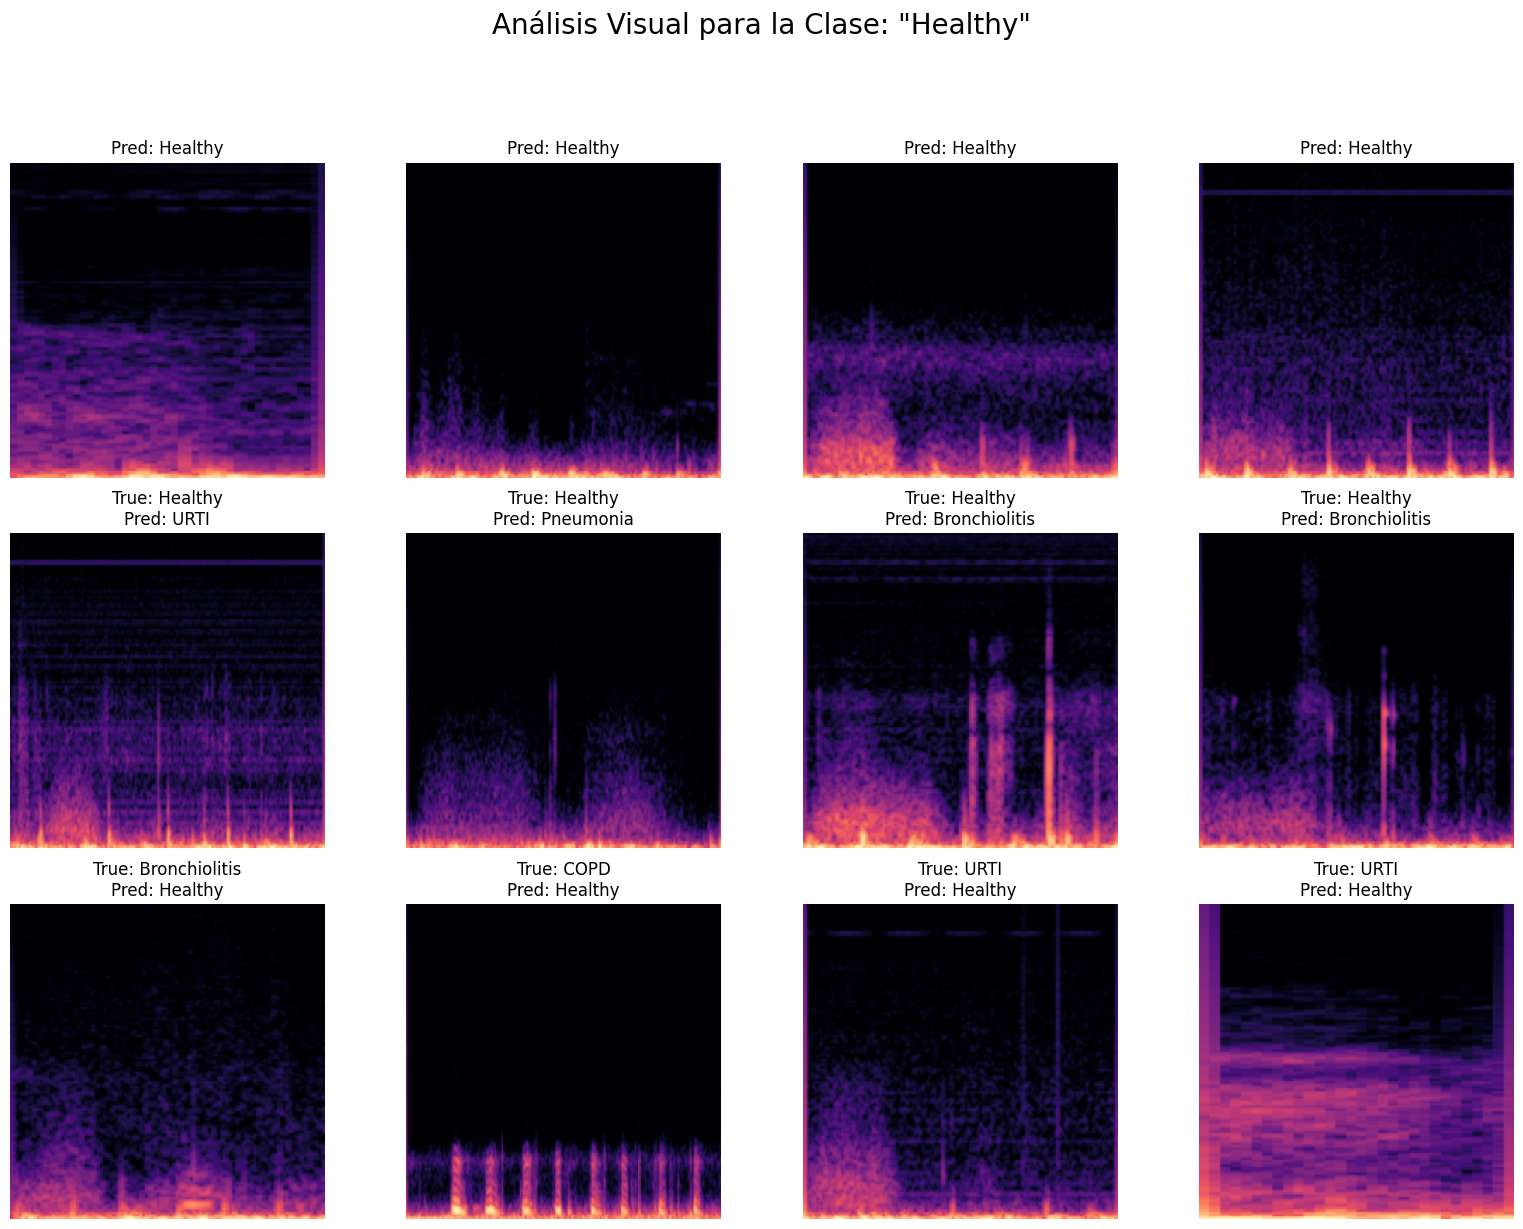

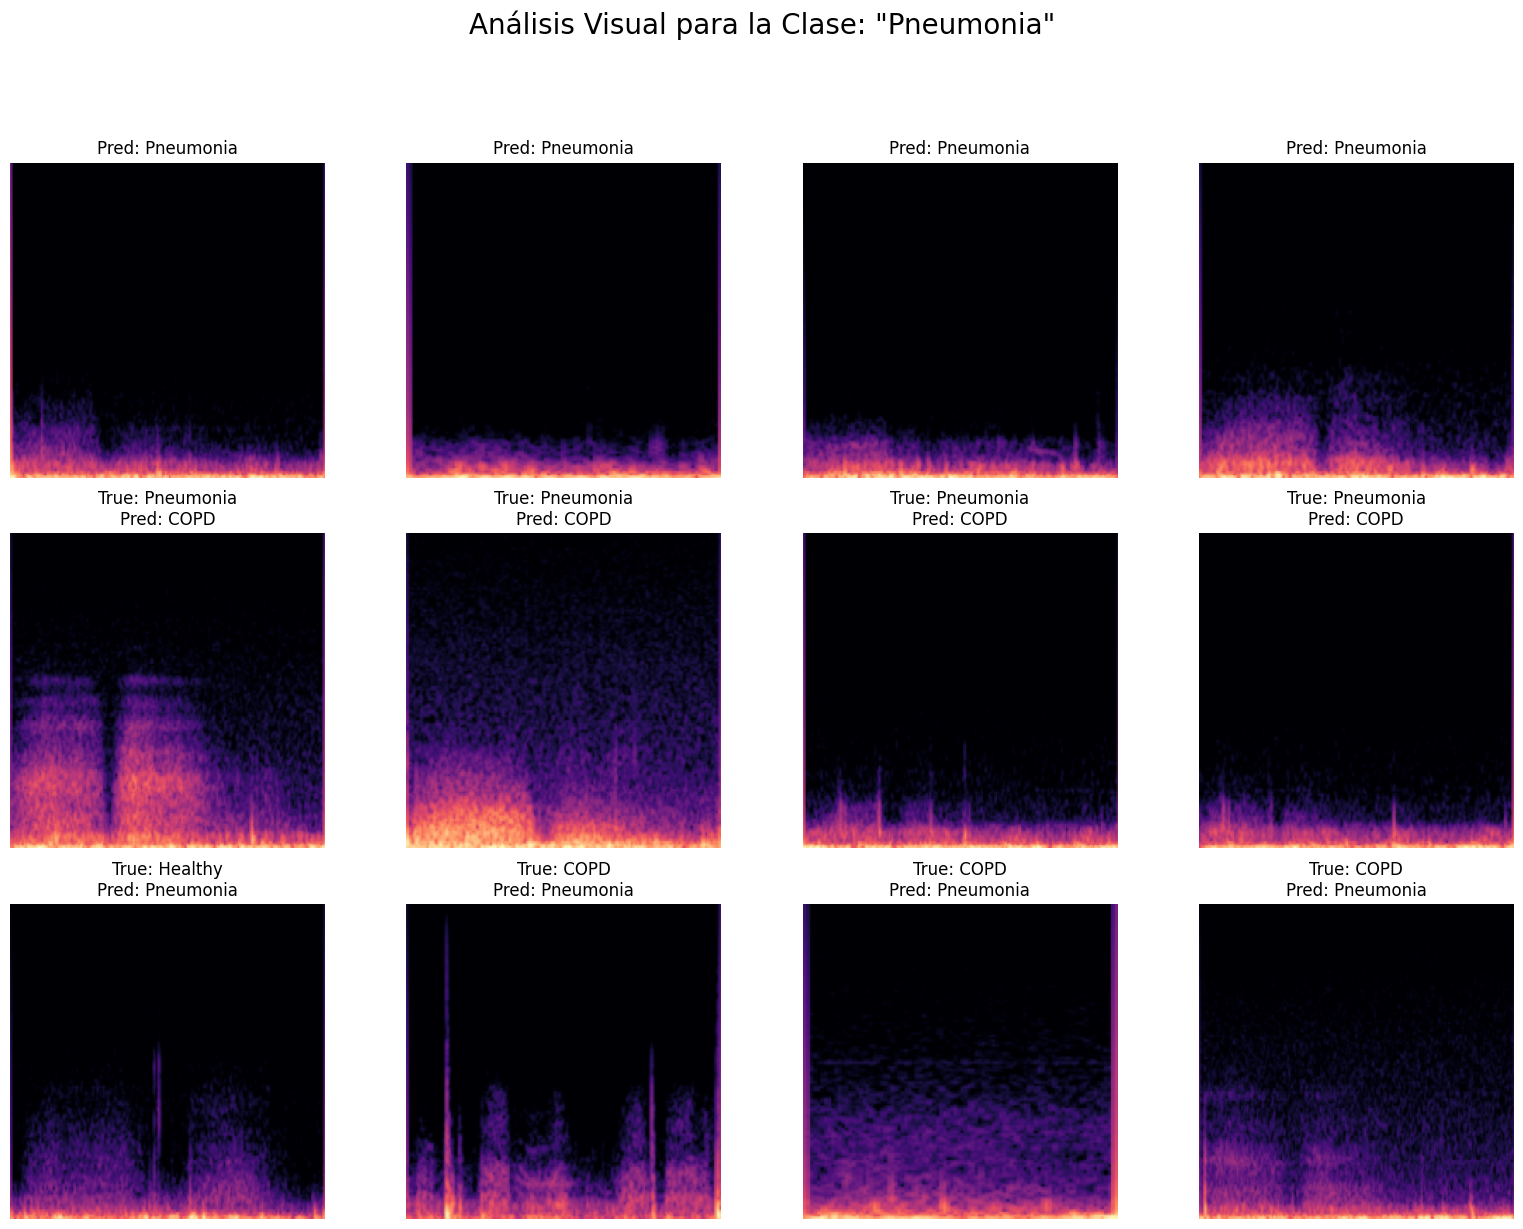

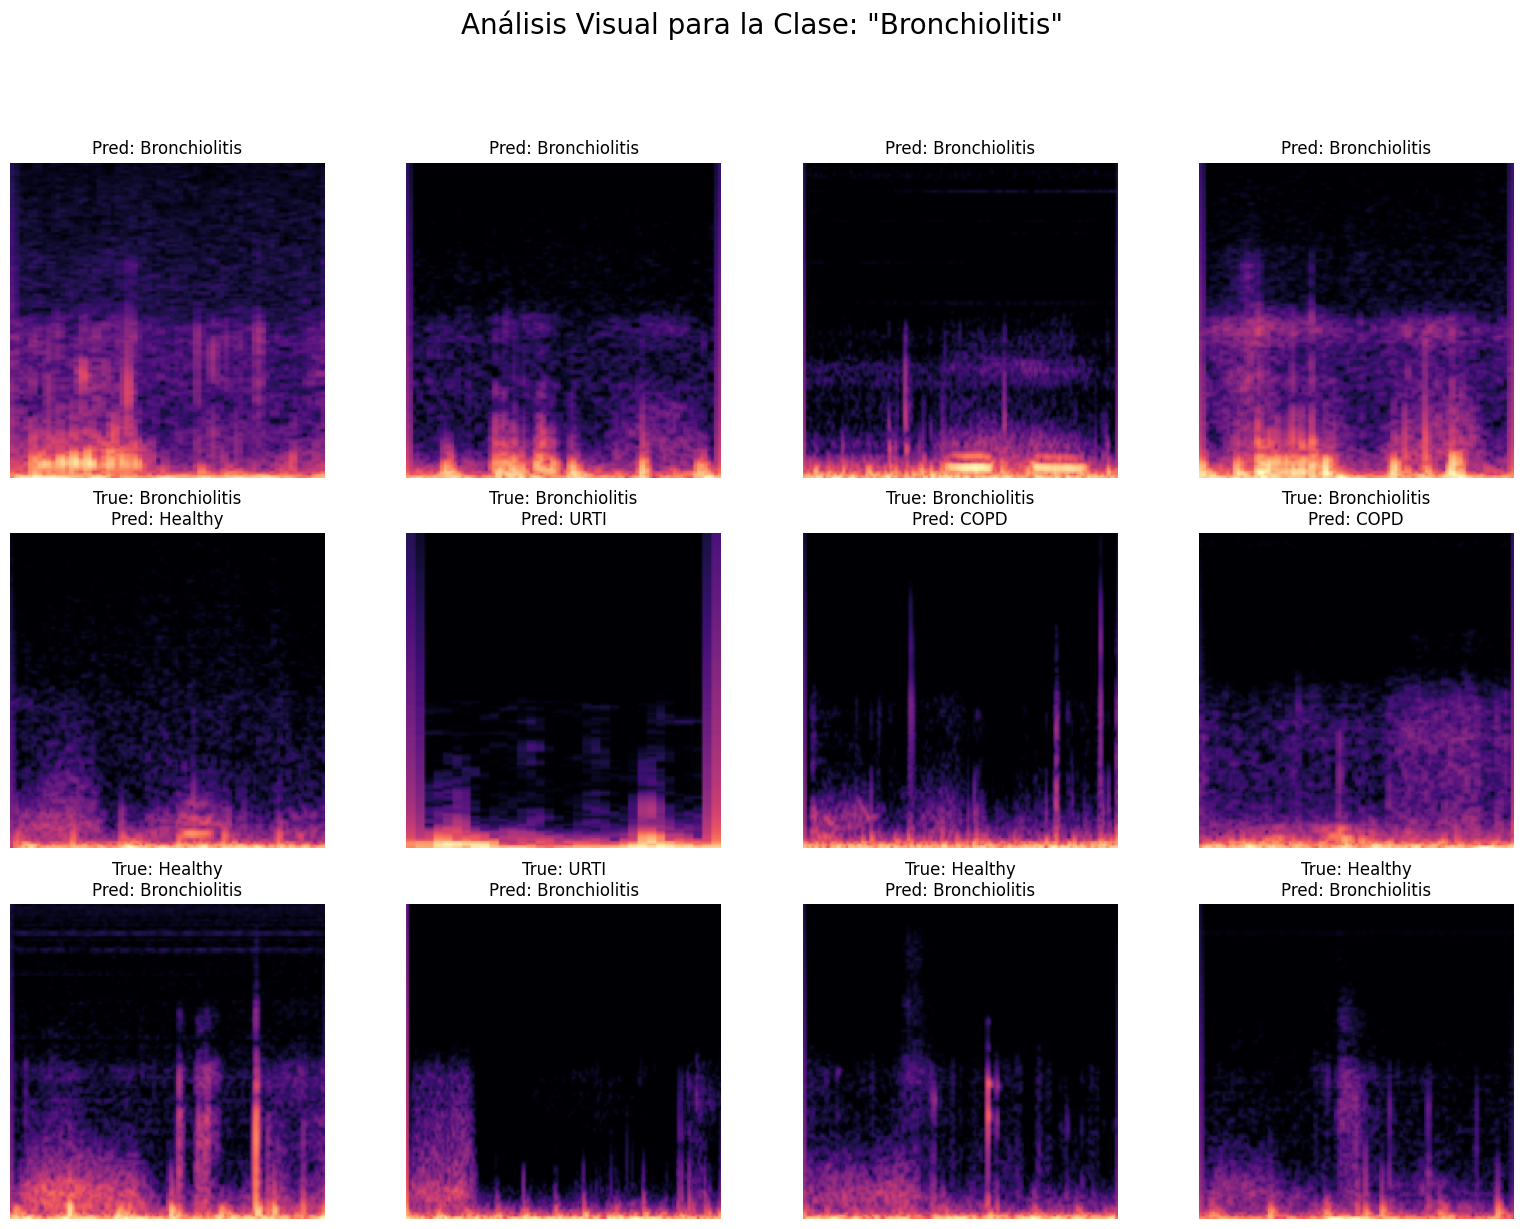

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# --- 1. PREPARACIÓN ---
# Asumimos que las variables `model_2d`, `test_loader`, `DEVICE`, `class_names`, 
# `imagenet_mean`, y `imagenet_std` ya existen.

# Recrear la función para desnormalizar imágenes para visualizarlas
denormalize = transforms.Normalize(
   mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
   std=[1/s for s in imagenet_std]
)

# Obtener todas las predicciones y etiquetas del conjunto de prueba si no existen
if 'all_preds' not in locals() or 'all_labels' not in locals():
    logger.info("Generando predicciones para el análisis visual...")
    all_preds = []; all_labels = []
    model_2d.to(DEVICE).eval()
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Generando Predicciones"):
            inputs = inputs.to(DEVICE)
            outputs = model_2d(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())

# --- 2. FUNCIÓN DE VISUALIZACIÓN PROFESIONAL ---
def plot_class_analysis(target_class_name: str, num_examples: int = 4):
    """
    Genera un informe visual para una clase objetivo, mostrando ejemplos de
    Verdaderos Positivos, Falsos Negativos y Falsos Positivos.
    """
    target_idx = class_names.index(target_class_name)
    
    # Encontrar los índices de cada categoría
    tp_indices = np.where((np.array(all_preds) == target_idx) & (np.array(all_labels) == target_idx))[0]
    fn_indices = np.where((np.array(all_preds) != target_idx) & (np.array(all_labels) == target_idx))[0]
    fp_indices = np.where((np.array(all_preds) == target_idx) & (np.array(all_labels) != target_idx))[0]

    # Crear la figura
    fig, axes = plt.subplots(3, num_examples, figsize=(num_examples * 4, 12))
    fig.suptitle(f'Análisis Visual para la Clase: "{target_class_name}"', fontsize=20, y=1.02)

    # --- Graficar Verdaderos Positivos (TP) ---
    axes[0, 0].set_ylabel('Verdaderos\nPositivos', fontsize=14, rotation=0, labelpad=80, verticalalignment='center')
    for i in range(num_examples):
        ax = axes[0, i]
        if i < len(tp_indices):
            img_idx = tp_indices[i]
            img_tensor, _ = test_dataset[img_idx]
            img_vis = denormalize(img_tensor).permute(1, 2, 0).numpy()
            ax.imshow(img_vis)
            ax.set_title(f"Pred: {target_class_name}")
        ax.axis('off')

    # --- Graficar Falsos Negativos (FN) ---
    axes[1, 0].set_ylabel('Falsos\nNegativos', fontsize=14, rotation=0, labelpad=80, verticalalignment='center')
    for i in range(num_examples):
        ax = axes[1, i]
        if i < len(fn_indices):
            img_idx = fn_indices[i]
            img_tensor, _ = test_dataset[img_idx]
            img_vis = denormalize(img_tensor).permute(1, 2, 0).numpy()
            ax.imshow(img_vis)
            pred_class = class_names[all_preds[img_idx]]
            ax.set_title(f"True: {target_class_name}\nPred: {pred_class}")
        ax.axis('off')

    # --- Graficar Falsos Positivos (FP) ---
    axes[2, 0].set_ylabel('Falsos\nPositivos', fontsize=14, rotation=0, labelpad=80, verticalalignment='center')
    for i in range(num_examples):
        ax = axes[2, i]
        if i < len(fp_indices):
            img_idx = fp_indices[i]
            img_tensor, _ = test_dataset[img_idx]
            img_vis = denormalize(img_tensor).permute(1, 2, 0).numpy()
            ax.imshow(img_vis)
            true_class = class_names[all_labels[img_idx]]
            ax.set_title(f"True: {true_class}\nPred: {target_class_name}")
        ax.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- 3. EJECUCIÓN DEL ANÁLISIS ---
# Genera los informes para las clases más interesantes
plot_class_analysis('Healthy')
plot_class_analysis('Pneumonia')
plot_class_analysis('Bronchiolitis') # Una de las clases con bajo rendimiento